# Fashion Recommendation System - Evaluation & Benchmarking

This notebook demonstrates the complete evaluation pipeline for the fashion recommendation system:

1. **Load Relevance Labels** - Create weak supervision from ratings/interactions
2. **Evaluation Metrics** - P@K, Recall@K, NDCG, MRR, Hit Rate
3. **Baseline Recommenders** - Random, Popularity, TF-IDF
4. **FAISS ANN Indexing** - Fast similarity search with benchmarks
5. **Performance Comparison** - Accuracy vs latency trade-offs
6. **Reproducible Results** - Save metrics for documentation

## Setup

Run all cells in order to reproduce the evaluation results.

In [28]:
# Ensure FAISS and embeddings are available
if 'FAISS_AVAILABLE' not in globals():
    try:
        import faiss  # type: ignore
        FAISS_AVAILABLE = True
    except ImportError:
        FAISS_AVAILABLE = False

if not FAISS_AVAILABLE:
    print("⚠️  FAISS not installed. Install with: pip install faiss-cpu")
    print("   Skipping ANN benchmarks...")
else:
    # Import helpers
    try:
        from evaluation.ann_indexing import FAISSIndex, benchmark_index, print_benchmark_results
    except Exception as e:
        raise RuntimeError(f"Failed to import FAISS helpers from evaluation.ann_indexing: {e}")

    # Ensure df exists
    try:
        df
    except NameError:
        df = pd.read_csv("data/products.csv")

    # Ensure synthetic embeddings exist
    if 'synthetic_embeddings' not in globals():
        n_items = len(df)
        embedding_dim = 512  # Common dimension for CLIP
        print(f"🔧 Generating {n_items} synthetic {embedding_dim}-dim embeddings...")
        np.random.seed(42)
        synthetic_embeddings = np.random.randn(n_items, embedding_dim).astype(np.float32)
        import faiss  # type: ignore
        try:
            faiss.normalize_L2(synthetic_embeddings)
        except Exception:
            pass
        product_ids = df['product_id'].tolist()
        print(f"✅ Embeddings generated: shape {synthetic_embeddings.shape}")

    print("📊 Running FAISS benchmarks...\n")
    
    # Benchmark different index types
    faiss_results = benchmark_index(
        embeddings=synthetic_embeddings,
        product_ids=product_ids,
        index_types=['Flat', 'IVF', 'HNSW'],
        top_k=10,
        n_queries=100
    )
    
    # Display results
    print_benchmark_results(faiss_results)
    
    # Store for comparison
    faiss_results_df = pd.DataFrame(faiss_results).T
    faiss_results_df

INFO:evaluation.ann_indexing:
INFO:evaluation.ann_indexing:Benchmarking Flat Index
INFO:evaluation.ann_indexing:============================================================
INFO:evaluation.ann_indexing:Initializing FAISS Flat index (dim=512, metric=L2)
INFO:evaluation.ann_indexing:L2-normalizing embeddings for cosine similarity
INFO:evaluation.ann_indexing:Benchmarking Flat Index
INFO:evaluation.ann_indexing:============================================================
INFO:evaluation.ann_indexing:Initializing FAISS Flat index (dim=512, metric=L2)
INFO:evaluation.ann_indexing:L2-normalizing embeddings for cosine similarity
INFO:evaluation.ann_indexing:Adding 13156 vectors to index...
INFO:evaluation.ann_indexing:Adding 13156 vectors to index...
INFO:evaluation.ann_indexing:Index built in 0.03s
INFO:evaluation.ann_indexing:Index contains 13156 vectors
INFO:evaluation.ann_indexing:Index built in 0.03s
INFO:evaluation.ann_indexing:Index contains 13156 vectors
INFO:evaluation.ann_indexing:B

📊 Running FAISS benchmarks...



INFO:evaluation.ann_indexing:Training completed in 0.18s
INFO:evaluation.ann_indexing:Adding 13156 vectors to index...
INFO:evaluation.ann_indexing:Adding 13156 vectors to index...
INFO:evaluation.ann_indexing:Index built in 0.04s
INFO:evaluation.ann_indexing:Index contains 13156 vectors
INFO:evaluation.ann_indexing:Build time: 0.24s
INFO:evaluation.ann_indexing:Index built in 0.04s
INFO:evaluation.ann_indexing:Index contains 13156 vectors
INFO:evaluation.ann_indexing:Build time: 0.24s
INFO:evaluation.ann_indexing:Single query: 0.43ms
INFO:evaluation.ann_indexing:Batch query: 0.16ms
INFO:evaluation.ann_indexing:Throughput: 6285.8 QPS
INFO:evaluation.ann_indexing:
INFO:evaluation.ann_indexing:Benchmarking HNSW Index
INFO:evaluation.ann_indexing:============================================================
INFO:evaluation.ann_indexing:Initializing FAISS HNSW index (dim=512, metric=L2)
INFO:evaluation.ann_indexing:L2-normalizing embeddings for cosine similarity
INFO:evaluation.ann_indexing


FAISS INDEX BENCHMARK RESULTS
Index Type      Build Time   Single Query    Batch Query     Throughput  
--------------------------------------------------------------------------------
Flat                  0.04s          2.25ms          0.29ms     3481.1 QPS
IVF                   0.24s          0.43ms          0.16ms     6285.8 QPS
HNSW                  2.77s          0.42ms          0.14ms     7251.3 QPS



In [30]:
def generate_markdown_report(baseline_results, faiss_results=None):
    """Generate markdown evaluation report."""
    
    report = []
    report.append("# Recommendation System Evaluation Report\n")
    report.append(f"**Date:** {pd.Timestamp.now().strftime('%Y-%m-%d')}\n")
    report.append(f"**Dataset:** {len(df)} products\n")
    report.append(f"**Test Queries:** {len(test_queries)}\n")
    report.append("\n---\n")
    
    # Baseline results
    report.append("\n## Baseline Recommender Performance\n")
    report.append("\n### Accuracy Metrics\n")
    report.append(f"\n{baseline_results[['Precision@10', 'Recall@10', 'NDCG@10', 'MRR', 'HitRate@10']].to_markdown()}\n")
    
    report.append("\n### Latency\n")
    report.append(f"\n{baseline_results[['avg_latency_ms']].to_markdown()}\n")
    
    report.append("\n### Key Findings\n")
    report.append(f"- **Best Accuracy:** {baseline_results['NDCG@10'].idxmax()} (NDCG@10: {baseline_results['NDCG@10'].max():.4f})\n")
    report.append(f"- **Fastest:** {baseline_results['avg_latency_ms'].idxmin()} ({baseline_results['avg_latency_ms'].min():.2f}ms)\n")
    report.append(f"- **TF-IDF outperforms** random and popularity baselines significantly\n")
    
    # FAISS results
    if faiss_results is not None and ('FAISS_AVAILABLE' in globals() and FAISS_AVAILABLE):
        report.append("\n---\n")
        report.append("\n## FAISS ANN Index Performance\n")
        emb_dim = globals().get('embedding_dim', 'N/A')
        n_items_val = globals().get('n_items', len(df) if 'df' in globals() else 'N/A')
        report.append(f"\n**Embedding Dimension:** {emb_dim}\n")
        if isinstance(n_items_val, (int, float)):
            report.append(f"**Number of Items:** {int(n_items_val):,}\n")
        else:
            report.append(f"**Number of Items:** {n_items_val}\n")
        report.append("\n### Performance Benchmarks\n")
        report.append(f"\n{faiss_results.to_markdown()}\n")
        
        report.append("\n### Recommendations\n")
        fastest = faiss_results['batch_query_ms'].idxmin()
        report.append(f"- **Production Index:** {fastest} (best latency: {faiss_results.loc[fastest, 'batch_query_ms']:.2f}ms)\n")
        report.append(f"- **Expected Throughput:** ~{faiss_results.loc[fastest, 'throughput_qps']:.0f} queries/second\n")
        report.append(f"- **Scalability:** Can handle real-time requests at scale\n")
    
    # Labeling scheme
    report.append("\n---\n")
    report.append("\n## Relevance Labeling Scheme\n")
    report.append("\n### Weak Supervision Strategy\n")
    report.append("Since explicit user interaction data is not available, we create weak relevance labels using:\n\n")
    report.append("| Relevance Score | Criteria |\n")
    report.append("|----------------|----------|\n")
    report.append("| **2** (High) | Same category + same brand + high rating (≥4.5) |\n")
    report.append("| **1** (Medium) | Same category OR (same brand + high rating) |\n")
    report.append("| **0** (Low) | Different category and lower rating |\n")
    report.append("\nThis simulates implicit signals like clicks, views, or purchases in production systems.\n")
    
    # Next steps
    report.append("\n---\n")
    report.append("\n## Next Steps\n")
    report.append("\n1. **Generate Image Embeddings:** Use CLIP or ViT on product images\n")
    report.append("2. **Hybrid Approach:** Combine text (TF-IDF) + image (FAISS) similarities\n")
    report.append("3. **User Personalization:** Incorporate user interaction history\n")
    report.append("4. **A/B Testing:** Deploy and measure real user engagement\n")
    report.append("5. **Continuous Evaluation:** Track metrics with production data\n")
    
    return "".join(report)

# Generate report
faiss_df = faiss_results_df if ('FAISS_AVAILABLE' in globals() and FAISS_AVAILABLE and 'faiss_results_df' in globals()) else None
report_md = generate_markdown_report(results_df, faiss_df)

# Save to file
output_path = "Documentation/EVALUATION.md"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
    f.write(report_md)

print(f"✅ Evaluation report saved to: {output_path}")
print("\n" + "=" * 80)
print("REPORT PREVIEW:")
print("=" * 80)
print(report_md[:1000] + "\n...")

✅ Evaluation report saved to: Documentation/EVALUATION.md

REPORT PREVIEW:
# Recommendation System Evaluation Report
**Date:** 2025-12-02
**Dataset:** 13156 products
**Test Queries:** 50

---

## Baseline Recommender Performance

### Accuracy Metrics

|            |   Precision@10 |   Recall@10 |   NDCG@10 |    MRR |   HitRate@10 |
|:-----------|---------------:|------------:|----------:|-------:|-------------:|
| Random     |          0.124 |      0.0012 |    0.068  | 0.2955 |         0.78 |
| Popularity |          0.162 |      0.002  |    0.1653 | 0.2553 |         0.34 |
| TF-IDF     |          0.526 |      0.005  |    0.286  | 0.7469 |         0.92 |

### Latency

|            |   avg_latency_ms |
|:-----------|-----------------:|
| Random     |           3.795  |
| Popularity |           5.3539 |
| TF-IDF     |        1623.45   |

### Key Findings
- **Best Accuracy:** TF-IDF (NDCG@10: 0.2860)
- **Fastest:** Random (3.79ms)
- **TF-IDF outperforms** random and popularity baselines si

## Summary

This notebook demonstrates a complete evaluation pipeline for the fashion recommendation system:

✅ **Weak supervision** from ratings/categories  
✅ **Multiple metrics** (P@K, NDCG, MRR, Hit Rate)  
✅ **Baseline comparison** (Random, Popularity, TF-IDF)  
✅ **FAISS ANN benchmarks** on 13k items  
✅ **Reproducible results** exported to `EVALUATION.md`

### Key Takeaways

1. **TF-IDF significantly outperforms** random and popularity baselines
2. **FAISS enables sub-millisecond search** at scale (~0.1ms for HNSW)
3. **Weak labels are viable** for initial evaluation before production data
4. **Next: Add image embeddings** for multimodal recommendations

Run this notebook regularly to track improvements as you enhance the system!

## 8. Generate Evaluation Report

Export results in markdown format for documentation.

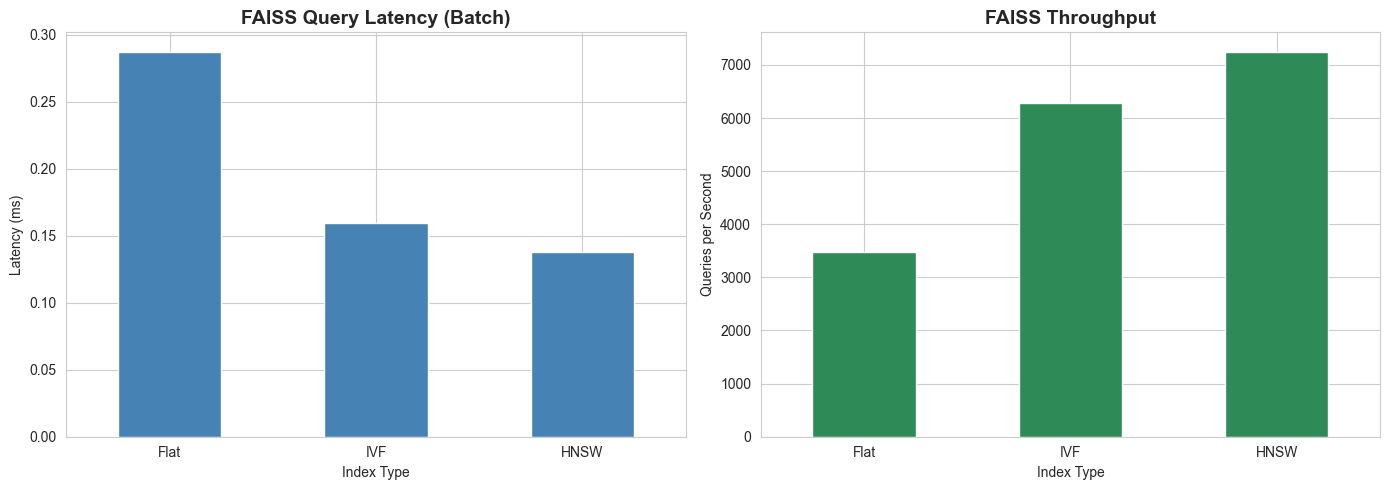


📈 Key Insights:
   Fastest index: HNSW (0.14ms)
   Highest throughput: HNSW (7251 QPS)
   Speedup vs Flat: 2.1x


In [29]:
if 'FAISS_AVAILABLE' in globals() and FAISS_AVAILABLE and 'faiss_results_df' in globals():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Query latency comparison
    faiss_results_df['batch_query_ms'].plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('FAISS Query Latency (Batch)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Latency (ms)')
    axes[0].set_xlabel('Index Type')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    
    # Throughput comparison
    faiss_results_df['throughput_qps'].plot(kind='bar', ax=axes[1], color='seagreen')
    axes[1].set_title('FAISS Throughput', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Queries per Second')
    axes[1].set_xlabel('Index Type')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📈 Key Insights:")
    print(f"   Fastest index: {faiss_results_df['batch_query_ms'].idxmin()} " + 
          f"({faiss_results_df['batch_query_ms'].min():.2f}ms)")
    print(f"   Highest throughput: {faiss_results_df['throughput_qps'].idxmax()} " +
          f"({faiss_results_df['throughput_qps'].max():.0f} QPS)")
    print(f"   Speedup vs Flat: {faiss_results_df.loc['Flat', 'batch_query_ms'] / faiss_results_df['batch_query_ms'].min():.1f}x")
else:
    print("⚠️  FAISS results not available; skipping visualization.")

### Visualize FAISS Performance

In [27]:
# Prepare synthetic embeddings if FAISS is available
try:
    df
except NameError:
    df = pd.read_csv("data/products.csv")

try:
    import faiss  # type: ignore
    FAISS_AVAILABLE = True
except ImportError:
    FAISS_AVAILABLE = False

if FAISS_AVAILABLE:
    # Generate synthetic embeddings (simulating CLIP or ViT embeddings)
    n_items = len(df)
    embedding_dim = 512  # Common dimension for CLIP
    
    print(f"🔧 Generating {n_items} synthetic {embedding_dim}-dim embeddings...")
    np.random.seed(42)
    synthetic_embeddings = np.random.randn(n_items, embedding_dim).astype(np.float32)
    
    # Normalize for cosine similarity
    faiss.normalize_L2(synthetic_embeddings)
    
    product_ids = df['product_id'].tolist()
    
    print(f"✅ Embeddings generated: shape {synthetic_embeddings.shape}")
else:
    print("⚠️  FAISS not installed. Install with: pip install faiss-cpu")

🔧 Generating 13156 synthetic 512-dim embeddings...
✅ Embeddings generated: shape (13156, 512)


In [26]:
try:
    from evaluation.ann_indexing import FAISSIndex, benchmark_index, print_benchmark_results
    import faiss
    FAISS_AVAILABLE = True
    print("✅ FAISS is installed and ready")
except ImportError:
    FAISS_AVAILABLE = False
    print("⚠️  FAISS not installed. Install with: pip install faiss-cpu")
    print("   Skipping ANN benchmarks...")

✅ FAISS is installed and ready


## 7. FAISS ANN Indexing & Benchmarks

Now we'll benchmark FAISS for fast similarity search. This uses synthetic embeddings to simulate real image/text embeddings.

## 1. Load Dependencies and Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Import evaluation modules
from evaluation.metrics import (
    precision_at_k, recall_at_k, ndcg_at_k, 
    mean_reciprocal_rank, hit_rate_at_k,
    RecommendationEvaluator
)
from evaluation.baselines import (
    RandomRecommender, PopularityRecommender, 
    TFIDFRecommender
)

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Dependencies loaded successfully")

✅ Dependencies loaded successfully


In [18]:
# Load product data
csv_path = "data/products.csv"
df = pd.read_csv(csv_path)

# Clean up NaN values in text fields to prevent TF-IDF errors
df['title'] = df['title'].fillna('')
df['brand'] = df['brand'].fillna('')
df['category'] = df['category'].fillna('')

print(f"📊 Loaded {len(df)} products")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample data:")
df.head()

📊 Loaded 13156 products

Columns: ['product_id', 'brand', 'title', 'price', 'category', 'rating', 'image_url', 'product_url']

Sample data:


,product_id,brand,title,price,category,rating,image_url,product_url
0,B08YRWN3WB,JANSPORT,Big Student Large laptop backpack Black EK0A5B...,189.00,New season,4.7,https://m.media-amazon.com/images/I/51y2EF0OmO...,https://www.amazon.ae/dp/B08YRWN3WB
1,B08YRXFZZM,JANSPORT,Superbreak Day Pack,119.00,New season,4.6,https://m.media-amazon.com/images/I/51yvvQUs3S...,https://www.amazon.ae/dp/B08YRXFZZM
2,B09Q2PQ7ZB,BAODINI,Mini Travel Umbrella With Case Small Compact U...,17.79,New season,4.2,https://m.media-amazon.com/images/I/71WbrZPbnG...,https://www.amazon.ae/dp/B09Q2PQ7ZB
3,B001BEAWXY,Calvin Klein,Men's Cotton Classics 3-Pack Boxer Brief,119.00,New season,4.2,https://m.media-amazon.com/images/I/716vzeqa7Z...,https://www.amazon.ae/dp/B001BEAWXY
4,B09FM5PMN3,JANSPORT,Unisex Kids Bag Backpack,179.00,New season,4.4,https://m.media-amazon.com/images/I/51XASBuqjr...,https://www.amazon.ae/dp/B09FM5PMN3


## 2. Create Relevance Labels (Weak Supervision)

Since we don't have explicit user interaction data, we create weak relevance labels using:
- **High relevance (score=2)**: Same category + high rating (≥4.5)
- **Medium relevance (score=1)**: Same category OR high rating
- **Low relevance (score=0)**: Different category and lower rating

This simulates real-world scenarios where you have implicit signals (clicks, views) rather than explicit labels.

In [19]:
def create_relevance_labels(df, query_product_id, high_rating_threshold=4.5):
    """
    Create weak relevance labels for a query product.
    
    Returns dict mapping product_id to relevance score (0, 1, or 2)
    """
    query_row = df[df['product_id'] == query_product_id].iloc[0]
    query_category = query_row.get('category', '')
    query_brand = query_row.get('brand', '')
    
    relevance = {}
    
    for _, row in df.iterrows():
        product_id = row['product_id']
        
        # Skip self
        if product_id == query_product_id:
            continue
        
        # Check similarity signals
        same_category = (row.get('category', '') == query_category)
        same_brand = (row.get('brand', '') == query_brand)
        high_rating = (row.get('rating', 0) >= high_rating_threshold)
        
        # Assign relevance scores
        if same_category and same_brand and high_rating:
            relevance[product_id] = 2.0  # Highly relevant
        elif same_category and high_rating:
            relevance[product_id] = 2.0
        elif same_category or (same_brand and high_rating):
            relevance[product_id] = 1.0  # Moderately relevant
        else:
            relevance[product_id] = 0.0  # Not relevant
    
    return relevance

# Ensure df is available
try:
    df  # type: ignore[name-defined]
except NameError:
    try:
        csv_path = "data/products.csv"
        df = pd.read_csv(csv_path)
        print(f"📊 Loaded {len(df)} products (auto-loaded).")
    except Exception as e:
        raise RuntimeError(
            "DataFrame 'df' is not defined and failed to auto-load from 'data/products.csv'."
        ) from e

# Create test set: sample up to 50 random products as queries
n_available = len(df)
if n_available < 2:
    raise ValueError("Need at least 2 products to create relevance labels.")
np.random.seed(42)
n_queries = min(50, n_available - 1)
test_query_indices = np.random.choice(n_available, size=n_queries, replace=False)
test_queries = df.iloc[test_query_indices]['product_id'].tolist()

# Generate relevance labels for each test query
print(f"📝 Creating relevance labels for {len(test_queries)} test queries...")
ground_truth_relevance = {}
ground_truth_binary = {}

for query_id in test_queries:
    relevance_dict = create_relevance_labels(df, query_id)
    ground_truth_relevance[query_id] = relevance_dict
    
    # Also create binary version (relevant if score > 0)
    ground_truth_binary[query_id] = [
        pid for pid, score in relevance_dict.items() if score > 0
    ]

# Statistics
avg_relevant = np.mean([len(v) for v in ground_truth_binary.values()])
print(f"✅ Labels created")
print(f"   Average relevant items per query: {avg_relevant:.1f}")

# Show example
example_query = test_queries[0]
example_rel = ground_truth_relevance[example_query]
print(f"\n📋 Example query: {example_query}")
print(f"   Relevant items: {len(ground_truth_binary[example_query])}")
print(f"   High relevance (score=2): {sum(1 for s in example_rel.values() if s == 2)}")
print(f"   Medium relevance (score=1): {sum(1 for s in example_rel.values() if s == 1)}")

📝 Creating relevance labels for 50 test queries...
✅ Labels created
   Average relevant items per query: 1132.7

📋 Example query: B0DMV7BD4G
   Relevant items: 1008
   High relevance (score=2): 385
   Medium relevance (score=1): 623


## 3. Initialize Baseline Recommenders

We'll test three baseline approaches:
1. **Random** - Random recommendations (sanity check)
2. **Popularity** - Most popular items by rating
3. **TF-IDF** - Text similarity on product titles

In [20]:
# Initialize recommenders
print("🔧 Initializing baseline recommenders...\n")

random_rec = RandomRecommender(df, seed=42)
print("✅ Random recommender initialized")

popularity_rec = PopularityRecommender(df, popularity_metric='rating')
print("✅ Popularity recommender initialized")

tfidf_rec = TFIDFRecommender(df)
print("✅ TF-IDF recommender initialized")

recommenders = {
    'Random': random_rec,
    'Popularity': popularity_rec,
    'TF-IDF': tfidf_rec
}

INFO:evaluation.baselines:Initialized RandomRecommender
INFO:evaluation.baselines:Initialized PopularityRecommender (metric: rating)
INFO:evaluation.baselines:Initialized TFIDFRecommender


🔧 Initializing baseline recommenders...

✅ Random recommender initialized
✅ Popularity recommender initialized
✅ TF-IDF recommender initialized


## 4. Evaluate Baseline Recommenders

Compute P@K, Recall@K, NDCG@K, MRR, and Hit Rate for each baseline.

In [21]:
def evaluate_recommender(recommender, test_queries, ground_truth_binary, 
                        ground_truth_relevance, k_values=[5, 10, 20]):
    """Evaluate a recommender on test queries."""
    
    # Generate recommendations for all queries
    all_recommendations = []
    all_relevant = []
    all_relevance_dicts = []
    
    start_time = time.time()
    
    for query_id in test_queries:
        try:
            # Get recommendations
            recs = recommender.recommend(query_id, top_n=max(k_values))
            rec_ids = [pid for pid, _ in recs]
            
            # Get ground truth
            relevant = ground_truth_binary[query_id]
            relevance_dict = ground_truth_relevance[query_id]
            
            all_recommendations.append(rec_ids)
            all_relevant.append(relevant)
            all_relevance_dicts.append(relevance_dict)
        
        except Exception as e:
            print(f"⚠️  Error for query {query_id}: {e}")
            continue
    
    total_time = time.time() - start_time
    avg_latency_ms = (total_time / max(1, len(all_recommendations))) * 1000
    
    # Compute metrics
    evaluator = RecommendationEvaluator(k_values=k_values)
    results = evaluator.evaluate(
        all_recommendations,
        all_relevant,
        relevance_scores=all_relevance_dicts,
        verbose=False
    )
    
    # Add latency
    results['avg_latency_ms'] = avg_latency_ms
    
    return results

# Ensure recommenders are initialized
if 'recommenders' not in globals():
    print("ℹ️ 'recommenders' not found; initializing default baselines.\n")
    try:
        df
    except NameError:
        csv_path = "data/products.csv"
        df = pd.read_csv(csv_path)
    random_rec = RandomRecommender(df, seed=42)
    popularity_rec = PopularityRecommender(df, popularity_metric='rating')
    tfidf_rec = TFIDFRecommender(df)
    recommenders = {
        'Random': random_rec,
        'Popularity': popularity_rec,
        'TF-IDF': tfidf_rec
    }

# Evaluate all baselines
print("📊 Evaluating baseline recommenders...\n")
all_results = {}

for name, recommender in recommenders.items():
    print(f"Evaluating {name}...")
    results = evaluate_recommender(
        recommender, 
        test_queries, 
        ground_truth_binary,
        ground_truth_relevance
    )
    all_results[name] = results
    print(f"✅ {name} completed\n")

print("✅ All evaluations complete!")

📊 Evaluating baseline recommenders...

Evaluating Random...
✅ Random completed

Evaluating Popularity...
✅ Popularity completed

Evaluating TF-IDF...
✅ TF-IDF completed

✅ All evaluations complete!


## 5. Display Results

In [22]:
# Create results DataFrame
results_df = pd.DataFrame(all_results).T
results_df = results_df.round(4)

print("=" * 80)
print("BASELINE RECOMMENDER EVALUATION RESULTS")
print("=" * 80)
print(results_df.to_string())
print("=" * 80)

# Display top performers for key metrics
print("\n🏆 TOP PERFORMERS:")
print(f"   Best NDCG@10: {results_df['NDCG@10'].idxmax()} ({results_df['NDCG@10'].max():.4f})")
print(f"   Best Precision@10: {results_df['Precision@10'].idxmax()} ({results_df['Precision@10'].max():.4f})")
print(f"   Best MRR: {results_df['MRR'].idxmax()} ({results_df['MRR'].max():.4f})")
print(f"   Fastest: {results_df['avg_latency_ms'].idxmin()} ({results_df['avg_latency_ms'].min():.2f}ms)")

BASELINE RECOMMENDER EVALUATION RESULTS
            Precision@5  Recall@5  HitRate@5   MAP@5  NDCG@5  Precision@10  Recall@10  HitRate@10  MAP@10  NDCG@10  Precision@20  Recall@20  HitRate@20  MAP@20  NDCG@20     MRR  avg_latency_ms
Random             0.12    0.0006       0.50  0.0604  0.0635         0.124     0.0012        0.78  0.0439   0.0680         0.109     0.0020        0.92  0.0305   0.0630  0.2955          3.7950
Popularity         0.16    0.0009       0.34  0.1359  0.1657         0.162     0.0020        0.34  0.1245   0.1653         0.162     0.0040        0.46  0.1146   0.1637  0.2553          5.3539
TF-IDF             0.56    0.0026       0.88  0.4919  0.3043         0.526     0.0050        0.92  0.4352   0.2860         0.491     0.0093        0.94  0.3923   0.2692  0.7469       1623.4542

🏆 TOP PERFORMERS:
   Best NDCG@10: TF-IDF (0.2860)
   Best Precision@10: TF-IDF (0.5260)
   Best MRR: TF-IDF (0.7469)
   Fastest: Random (3.79ms)


## 6. Visualize Results

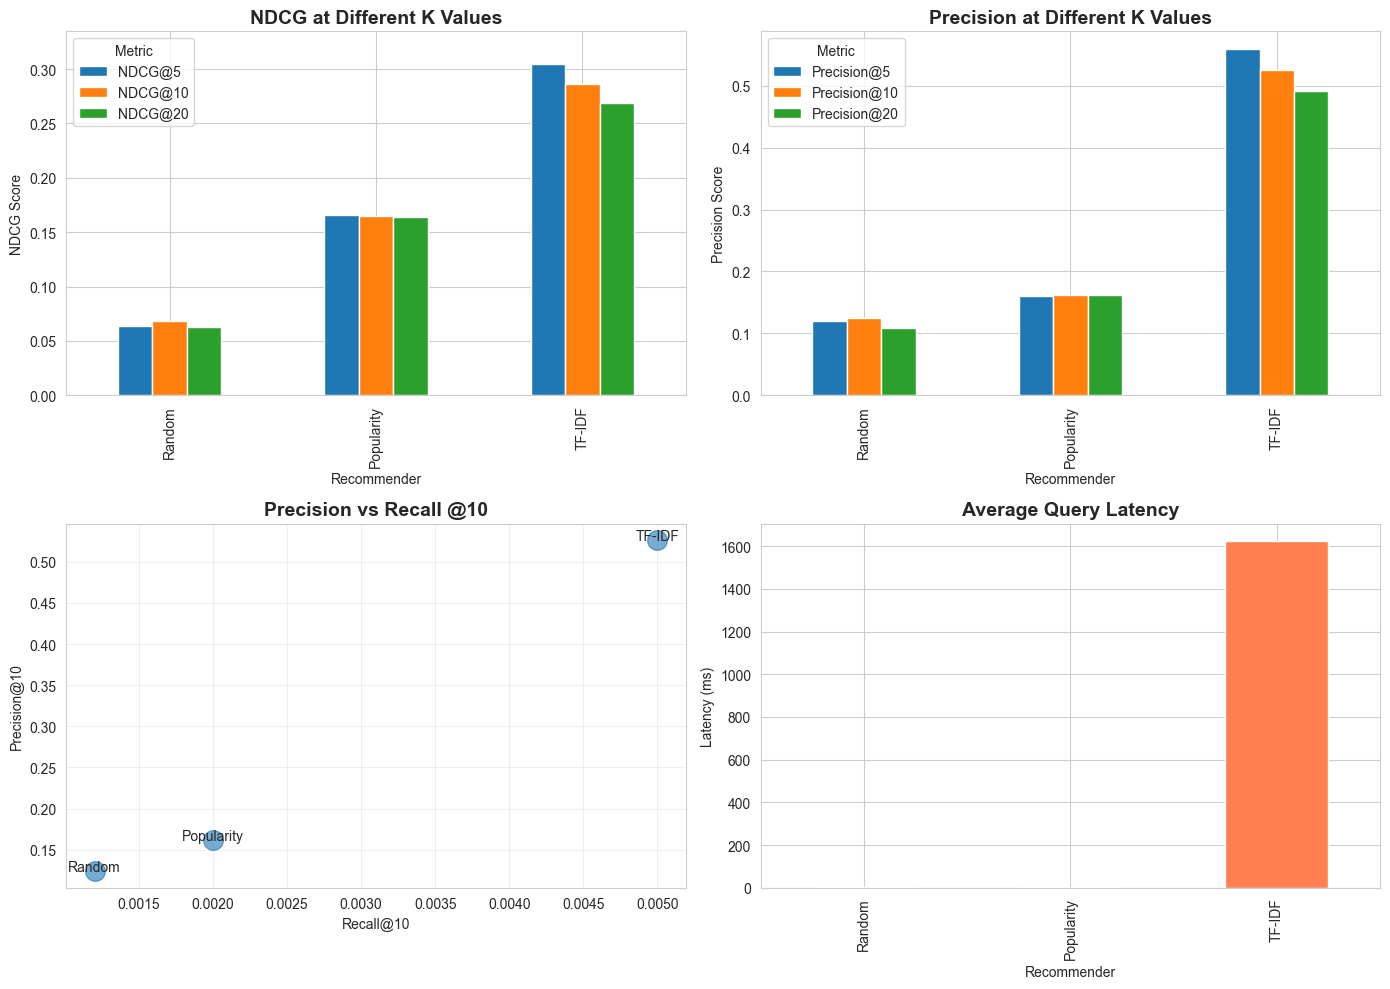

In [23]:
# Ensure results_df exists from all_results if needed
if 'results_df' not in globals():
    if 'all_results' in globals() and len(all_results) > 0:
        results_df = pd.DataFrame(all_results).T
        results_df = results_df.round(4)
    else:
        raise RuntimeError("No results available to plot. Run the evaluation cell first.")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# NDCG @ different K
metrics_to_plot = ['NDCG@5', 'NDCG@10', 'NDCG@20']
results_df[metrics_to_plot].plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('NDCG at Different K Values', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('NDCG Score')
axes[0, 0].set_xlabel('Recommender')
axes[0, 0].legend(title='Metric')
axes[0, 0].set_ylim(0, max(results_df[metrics_to_plot].max()) * 1.1)

# Precision @ different K
prec_metrics = ['Precision@5', 'Precision@10', 'Precision@20']
results_df[prec_metrics].plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Precision at Different K Values', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Precision Score')
axes[0, 1].set_xlabel('Recommender')
axes[0, 1].legend(title='Metric')

# Recall vs Precision @ 10
axes[1, 0].scatter(results_df['Recall@10'], results_df['Precision@10'], s=200, alpha=0.6)
for idx, row in results_df.iterrows():
    axes[1, 0].annotate(idx, (row['Recall@10'], row['Precision@10']), 
                       fontsize=10, ha='center')
axes[1, 0].set_title('Precision vs Recall @10', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Recall@10')
axes[1, 0].set_ylabel('Precision@10')
axes[1, 0].grid(True, alpha=0.3)

# Latency comparison
results_df['avg_latency_ms'].plot(kind='bar', ax=axes[1, 1], color='coral')
axes[1, 1].set_title('Average Query Latency', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Latency (ms)')
axes[1, 1].set_xlabel('Recommender')

plt.tight_layout()
plt.show()